# **Re**lative **Lo**ss **B**alancing with **Ra**ndom **Lo**okbacks for Helmholtz PDE
This notebook implements the concepts from the [Multi-Objective Loss Balancing for Physics-Informed Deep Learning paper](https://arxiv.org/abs/2110.09813) and [Improving PINNs through Adaptive Loss Balancing medium article](https://medium.com/p/55662759e701). It showcases the gains in performance when applying Loss Balancing Schemes to PINN training.



In [ ]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import math
sns.set_theme(style="whitegrid")

from typing import Tuple, Callable, List, Union
from tensorflow.experimental.numpy import isclose
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Utility functions
We start by defining a few utility functions that will be useful later. The first, *compute_derivatives*, computes all the derivatives necessary to formulate the Helmholtz PINN objective (it is a second order differential equation).



In [ ]:
def compute_derivatives(x, y, u):
    """
    Computes the derivatives of `u` with respect to `x` and `y`.

    Parameters
    ----------
    x : tf.Tensor
        The x-coordinate of the collocation points, of shape (batch_size, 1).
    y : tf.Tensor
        The y-coordinate of the collocation points, of shape (batch_size, 1).
    u : tf.Tensor
        The prediction made by the PINN, of shape (batch_size, 1).

    Returns
    -------
    tuple
        The second order derivatives of `u` with respect to `x`, `y`.
    """
    dudx, dudy = tf.gradients(u, [x, y])
    dudxx = tf.gradients(dudx, x)[0]
    dudyy = tf.gradients(dudy, y)[0]
    return dudxx, dudyy

## Define Helmholtz PDE Class (cas (a) avec une source en produit de sinus -> résoluble)

The Helmholtz equation is a partial differential equation that describes the propagation of waves in a medium. It is a second-order equation and named after the German physicist Hermann von Helmholtz. We can define the problem such that there exists an analytical solution, against which we can compare our PINN.

<!-- $$
    f(x, y) = (-\pi^2 - (4\pi)^2 + k^2) sin(\pi x) sin(4 \pi y) \\
    u(x, y) = sin(\pi x) sin(4 \pi y)\\
    u(-1, y) = u(1, y) = u(x, -1) = u(x, 1) = 0\\
$$ -->

This class represents the [Helmholtz PDE](https://en.wikipedia.org/wiki/Helmholtz_equation). It provides a set of utility functions to train a [Physics Informed Neural Network (PINN)](https://arxiv.org/pdf/1711.10566.pdf) on the Helmholtz PDE. The class has functions that generate training and validation data, calculate loss, and visualize the results of the PINN's predictions.

Define the problem such that there exists an analytical solution, against which we can compare our PINN:

$$
    u(x, y) = sin(k_x^* x) sin(k_y^* y)\\
$$

In [ ]:
kx = np.pi
ky = 2*np.pi
la = 2*np.pi/(np.sqrt(kx**2+ky**2))

In [ ]:
EPS = 1e-7

class HelmholtzPDE:
    """
    Class representing a Helmholtz pde, providing several methods for training a Physics-Informed Neural Network.
    """
    def __init__(self, u_val: Callable[[tf.Tensor, tf.Tensor], tf.Tensor]):
        """
        Initialize the HelmholtzPDE class.

        PARAMETERS
        ----------------
        u_val : Callable[[tf.Tensor, tf.Tensor], tf.Tensor]
            A function to validate the predictions.
        """
        self.u_val = u_val
        self.k = 2*math.pi
        self.num_terms = 2

    # def training_batch(self, num_points_per_dim:int=70) -> Tuple[tf.Tensor, tf.Tensor]:
    #     """
    #     Generates a batch of collocation points by creating a uniform grid of `num_points_per_dim` points
    #     along each dimension inside the domain and on the boundaries.

    #     PARAMETERS
    #     ----------
    #     num_points_per_dim : int
    #         The number of points per dimension inside the domain and on the boundaries.

    #     Returns
    #     -------
    #     x, y : Tuple[tf.Tensor, tf.Tensor]
    #         The x and y coordinates of the collocation points.
    #     """
    #     # Create a uniform grid for the inner domain
    #     x_in = np.linspace(-1, 1, num_points_per_dim)
    #     y_in = np.linspace(-1, 1, num_points_per_dim)
    #     x_in, y_in = np.meshgrid(x_in, y_in)
    #     x_in, y_in = x_in.flatten(), y_in.flatten()

    #     # Create points for the boundaries
    #     x_boundary = np.concatenate([-np.ones(num_points_per_dim), np.ones(num_points_per_dim),
    #                                 x_in, x_in])
    #     y_boundary = np.concatenate([y_in, y_in,
    #                                 -np.ones(num_points_per_dim), np.ones(num_points_per_dim)])

    #     # Combine inner and boundary points
    #     x = np.concatenate([x_in, x_boundary])
    #     y = np.concatenate([y_in, y_boundary])

    #     # Convert to tensors
    #     x = tf.convert_to_tensor(x[:, np.newaxis], dtype=tf.float32)
    #     y = tf.convert_to_tensor(y[:, np.newaxis], dtype=tf.float32)

    #     return x, y

    def training_batch(self, batch_size_domain:int=4000, batch_size_boundary:int=100) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Generates a batch of collocation points by randomly sampling `batch_size_domain` points inside the domain
        and `batch_size_boundary` points on each of the four boundaries.

        PARAMETERS
        --------------------
        batch_size_domain : int
            number of points to be sampled inside of the domain
        batch_size_boundary : int
            number of points to be sampled on each of the four boundaries
        """
        x_in =  tf.random.uniform(shape=(batch_size_domain, 1), minval=-1, maxval=1)
        x_b1 = -tf.ones(shape=(batch_size_boundary, 1))
        x_b2 =  tf.ones(shape=(batch_size_boundary, 1))
        x_b3 =  tf.random.uniform(shape=(batch_size_boundary, 1), minval=-1, maxval=1)
        x_b4 =  tf.random.uniform(shape=(batch_size_boundary, 1), minval=-1, maxval=1)
        x = tf.concat([x_in, x_b1, x_b2, x_b3, x_b4], axis=0)

        y_in =  tf.random.uniform(shape=(batch_size_domain, 1), minval=-1, maxval=1)
        y_b1 =  tf.random.uniform(shape=(batch_size_boundary, 1), minval=-1, maxval=1)
        y_b2 =  tf.random.uniform(shape=(batch_size_boundary, 1), minval=-1, maxval=1)
        y_b3 = -tf.ones(shape=(batch_size_boundary, 1))
        y_b4 =  tf.ones(shape=(batch_size_boundary, 1))
        y = tf.concat([y_in, y_b1, y_b2, y_b3, y_b4], axis=0)

        self.last_x_train = x # new line
        self.last_y_train = y # new line

        return x, y


    # def get_train_dataset(self, num_points_per_dim:int=70):
    #     """
    #     Creates a tf.data.Dataset generator for training.

    #     Parameters
    #     ----------
    #     batch_size_domain : int
    #         number of points to be sampled inside of the domain. Default is 800.
    #     batch_size_boundary : int
    #         number of points to be sampled on each of the four boundaries. Default is 100.

    #     Returns
    #     -------
    #     tf.data.Dataset
    #         A `tf.data.Dataset` generator for training.
    #     """
    #     def generator():
    #         while True:
    #             xy = tf.concat(self.training_batch(num_points_per_dim), axis=-1)
    #             yield xy, xy

    #     return tf.data.Dataset.from_generator(
    #         generator,
    #         output_types=(tf.float32, tf.float32),
    #         output_shapes=((None, 2), (None, 2))
    #     )

    def get_train_dataset(self, batch_size_domain:int=4000, batch_size_boundary:int=100):
        """
        Creates a tf.data.Dataset generator for training.

        Parameters
        ----------
        batch_size_domain : int
            number of points to be sampled inside of the domain. Default is 800.
        batch_size_boundary : int
            number of points to be sampled on each of the four boundaries. Default is 100.

        Returns
        -------
        tf.data.Dataset
            A `tf.data.Dataset` generator for training.
        """
        def generator():
            while True:
                xy = tf.concat(self.training_batch(batch_size_domain, batch_size_boundary), axis=-1)
                yield xy, xy

        return tf.data.Dataset.from_generator(
            generator,
            output_types=(tf.float32, tf.float32),
            output_shapes=((None, 2), (None, 2))
        )


    def validation_batch(self, grid_width:int=64, grid_height:int=64):
        """
        Generates a grid of points that can easily be used to generate an image of the pde,
        where each point is a pixel.

        PARAMETERS
        ----------
        grid_width : int
            width of the grid
        grid_height : int
            height of the grid
        """
        x, y = np.mgrid[-1:1:complex(0, grid_width), -1:1:complex(0, grid_height)]
        x = tf.cast(x.reshape(grid_width * grid_height, 1), dtype=tf.float32)
        y = tf.cast(y.reshape(grid_width * grid_height, 1), dtype=tf.float32)
        # u = tf.math.sin(np.pi * x) * tf.math.sin(4 * np.pi * y)
        u = tf.math.sin(kx * x) * tf.math.sin(ky * y)
        return x, y, u

    def compute_loss(self, x, y, preds, eval=False):
        """
        Computes the physics-informed loss for Helmholtz's PDE.

        Parameters
        ----------
        x : tf.Tensor of shape (batch_size, 1)
            x coordinate of the points in the current batch
        y : tf.Tensor of shape (batch_size, 1)
            y coordinate of the points in the current batch
        preds : tf.Tensor of shape (batch_size, 6)
            predictions made by our PINN (dim 0) as well as dudxx (dim 1), dudyy (dim 2)
        """

        # governing equation loss
        L_f = (preds[:, 1:2] + preds[:, 2:3] + self.k**2 * preds[:, 0:1] - \
              (self.k**2 - kx**2 - ky**2) * tf.math.sin(kx * x) * tf.math.sin(ky * y))**2

        # determine which points are on the boundaries of the domain
        # if a point is on either of the boundaries, its value is 1 and 0 otherwise
        x_lower = tf.cast(isclose(x, -1, rtol=0., atol=EPS), dtype=tf.float32)
        x_upper = tf.cast(isclose(x,  1, rtol=0., atol=EPS), dtype=tf.float32)
        y_lower = tf.cast(isclose(y, -1, rtol=0., atol=EPS), dtype=tf.float32)
        y_upper = tf.cast(isclose(y,  1, rtol=0., atol=EPS), dtype=tf.float32)

        # compute 0th order boundary condition loss
        L_b = ((x_lower + x_upper + y_lower + y_upper) * preds[:, 0:1])**2

        if eval:
            L_u = (tf.math.sin(kx * x) * tf.math.sin(ky * y) - preds[:, 0:1])**2
            L_u1 = tf.abs(tf.math.sin(kx * x) * tf.math.sin(ky * y) - preds[:, 0:1])
            L_inf = tf.abs(tf.math.sin(kx * x) * tf.math.sin(ky * y) - preds[:, 0:1])
            return L_f, L_b, L_u, L_u1, L_inf

        return L_f, L_b

    @tf.function
    def __validation_results(self, pinn: tf.keras.Model, image_width: int = 64, image_height: int = 64):
        """Computes the validation results for the given model.

        Parameters
        ----------
        pinn : tf.keras.Model
            A TensorFlow Keras model instance.
        image_width : int
            The width of the image (defaults to 64).
        image_height : int
            The height of the image (defaults to 64).

        Returns:
        u_real : tf.Tensor
            A tensor containing the real displacement.
        u_pred : tf.Tensor
            A tensor containing the predicted displacement.
        f : tf.Tensor
            A tensor containing the governing equation.
        """
        x, y, u_real = self.validation_batch(image_width, image_height)
        pred = pinn(tf.concat([x, y], axis=-1), training=False)
        u_pred, dudxx, dudyy = pred[:, 0:1], pred[:, 1:2], pred[:, 2:3]
        sin_xy = tf.math.sin(kx * x) * tf.math.sin(ky * y)
        f = (dudxx + dudyy + self.k**2 * u_pred - (self.k**2 - kx**2-ky**2) * sin_xy)**2
        return u_real, u_pred, f


    # def visualise(self, pinn: tf.keras.Model = None, image_width: int = 64, image_height: int = 64):
    #     """
    #     If no model is provided, visualises only the load distribution on the plate.
    #     Otherwise, visualizes the results of the given model.

    #     Parameters
    #     ----------
    #     pinn : tf.keras.Model
    #         A TensorFlow Keras model instance.
    #     image_width : int
    #         The width of the image (defaults to 64).
    #     image_height : int
    #         The height of the image (defaults to 64).
    #     """
    #     if pinn is None:
    #         x, y, u_real = self.validation_batch(image_width, image_height)
    #         self.__show_image(u_real.numpy().reshape(image_width, image_height))
    #         plt.show()

    #     else:
    #         u_real, u_pred, f = self.__validation_results(pinn, image_width, image_height)
    #         u_real = u_real.numpy().reshape(image_width, image_height)
    #         u_pred = u_pred.numpy().reshape(image_width, image_height)
    #         f = f.numpy().reshape(image_width, image_height)

    #         fig, axs = plt.subplots(2, 2, figsize=(8, 7))
    #         self.__show_image(u_pred, axs[0, 0], 'Predicted')
    #         self.__show_image((u_pred - u_real)**2, axs[0, 1], 'Squared Error')
    #         self.__show_image(f, axs[1, 0], 'Governing Equation')
    #         self.__show_image(f**2, axs[1, 1], 'Squared Error Governing Equation')

    #         # Hide x labels and tick labels for top plots and y ticks for right plots.
    #         for ax in axs.flat:
    #             ax.label_outer()
    #         plt.tight_layout()
    #         plt.show()

    # def visualise(self, pinn: tf.keras.Model = None, image_width: int = 64, image_height: int = 64, x_grid=None, y_grid=None):
    #     """
    #     Visualizes the results of the given model along with the grid points.

    #     Parameters
    #     ----------
    #     pinn : tf.keras.Model, optional
    #         A TensorFlow Keras model instance. If None, visualizes only the load distribution.
    #     image_width : int
    #         The width of the image (defaults to 64).
    #     image_height : int
    #         The height of the image (defaults to 64).
    #     x_grid : np.array, optional
    #         X coordinates of the grid points to visualize.
    #     y_grid : np.array, optional
    #         Y coordinates of the grid points to visualize.
    #     """
    #     if pinn is None:
    #         x, y, u_real = self.validation_batch(image_width, image_height)
    #         self.__show_image(u_real.numpy().reshape(image_width, image_height))
    #         plt.show()
    #     else:
    #         u_real, u_pred, f = self.__validation_results(pinn, image_width, image_height)
    #         u_real = u_real.numpy().reshape(image_width, image_height)
    #         u_pred = u_pred.numpy().reshape(image_width, image_height)
    #         f = f.numpy().reshape(image_width, image_height)

    #         fig, axs = plt.subplots(2, 2, figsize=(8, 7))
    #         self.__show_image(u_pred, axs[0, 0], 'Predicted', x_grid, y_grid)
    #         self.__show_image((u_pred - u_real)**2, axs[0, 1], 'Squared Error', x_grid, y_grid)
    #         self.__show_image(f, axs[1, 0], 'Governing Equation', x_grid, y_grid)
    #         self.__show_image(f**2, axs[1, 1], 'Squared Error Governing Equation', x_grid, y_grid)

    #         for ax in axs.flat:
    #             ax.label_outer()
    #         plt.tight_layout()
    #         plt.show()

    # def __show_image(self, img:np.array, axis:plt.axis=None, title:str='', x_grid=None, y_grid=None, x_label='x', y_label='y', z_label=''):
    #     if axis is None:
    #         _, axis = plt.subplots(1, 1, figsize=(4, 3.2), dpi=100)
    #     im = axis.imshow(np.rot90(img, k=3), cmap='plasma', origin='lower', aspect='auto')
    #     if x_grid is not None and y_grid is not None:
    #         # Convert grid coordinates to image indices
    #         x_img = (x_grid + 1) * (img.shape[1] - 1) / 2
    #         y_img = (y_grid + 1) * (img.shape[0] - 1) / 2
    #         axis.scatter(x_img, y_img, color='black', s=1)  # s is the size of the point
    #     cb = plt.colorbar(im, label=z_label, ax=axis)
    #     axis.set_xticks([0, img.shape[0]-1])
    #     axis.set_xticklabels([-1, 1])
    #     axis.set_yticks([0, img.shape[1]-1])
    #     axis.set_yticklabels([-1, 1])
    #     axis.set_xlabel(x_label)
    #     axis.set_ylabel(y_label)
    #     axis.set_title(title)
    #     return im

    # def __show_image(self, img:np.array, axis:plt.axis=None, title:str='', x_label='x', y_label='y', z_label=''):
    #     if axis is None:
    #          _, axis = plt.subplots(1, 1, figsize=(4, 3.2), dpi=100)
    #     im = axis.imshow(np.rot90(img, k=3), cmap='plasma', origin='lower', aspect='auto')
    #     cb = plt.colorbar(im, label=z_label, ax=axis)
    #     axis.set_xticks([0, img.shape[0]-1])
    #     axis.set_xticklabels([-1, 1])
    #     axis.set_yticks([0, img.shape[1]-1])
    #     axis.set_yticklabels([-1, 1])
    #     axis.set_xlabel(x_label)
    #     axis.set_ylabel(y_label)
    #     axis.set_title(title)
    #     return im

    def visualise(self, pinn: tf.keras.Model = None, image_width: int = 64, image_height: int = 64):
        """
        Visualizes the results of the given model along with the last set of training batch collocation points.
        """
        # Check if the last training batch exists
        if hasattr(self, 'last_x_train') and hasattr(self, 'last_y_train'):
            # Assuming last_x_train and last_y_train are stored as tensors
            x_col, y_col = self.last_x_train.numpy(), self.last_y_train.numpy()
        else:
            # No training batch has been generated/stored yet
            x_col, y_col = None, None

        if pinn is None:
            x, y, u_real = self.validation_batch(image_width, image_height)
            fig, ax = plt.subplots(figsize=(6, 5))
            self.__show_image(u_real.numpy().reshape(image_width, image_height), ax, 'Load Distribution', x_col, y_col)
            plt.show()
        else:
            u_real, u_pred, f = self.__validation_results(pinn, image_width, image_height)
            u_real = u_real.numpy().reshape(image_width, image_height)
            u_pred = u_pred.numpy().reshape(image_width, image_height)
            f = f.numpy().reshape(image_width, image_height)

            fig, axs = plt.subplots(2, 2, figsize=(8, 7))
            self.__show_image(u_pred, axs[0, 0], 'Predicted Solution', x_col, y_col)
            self.__show_image(u_real, axs[0, 1], 'Analytical Solution', x_col, y_col)
            self.__show_image((u_pred - u_real)**2, axs[1, 0], 'Analytical Squared Error', x_col, y_col)
            self.__show_image(f, axs[1, 1], 'Governing Equation', x_col, y_col)

            plt.tight_layout()
            plt.show()


    def __show_image(self, img: np.array, axis, title: str = '', x_col=None, y_col=None):
        """
        Helper function to show images and optionally collocation points.

        Parameters:
        img: The image data to plot.
        axis: The matplotlib axis to plot on.
        title: Title for the subplot.
        x_col, y_col: Collocation points to be plotted over the image.
        """
        im = axis.imshow(np.rot90(img, k=3), cmap='plasma', extent=[-1, 1, -1, 1], origin='lower', aspect='auto')
        axis.set_title(title)
        if x_col is not None and y_col is not None:
            # Scale collocation points to the image coordinates
            axis.scatter(x_col, y_col, color='red', s=10, edgecolor='white', linewidth=0.5, alpha=0.6)
        axis.set_xlabel('x')
        axis.set_ylabel('y')
        plt.colorbar(im, ax=axis)

## Helmholtz PINN Loss Function

### Default Helmholtz PDE Loss
This class inherits from the keras Loss class and can be used in the keras API (i.e. model.fit()) for training our Helmholtz PINN.

In [ ]:
class HelmholtzLoss(tf.keras.losses.Loss):
    """
    Helmholtz Loss for physics-informed neural network.

    Parameters
    ----------
    pde: HelmholtzPDE
        The HelmholtzPDE object representing the PDE
        The name of the loss, by default 'ReLoBRaLoHelmholtzLoss'
    """
    def __init__(self, pde:HelmholtzPDE, name='HelmholtzLoss'):
        super().__init__(name=name)
        self.pde = pde

    def call(self, xy, preds):
        x, y = xy[:, :1], xy[:, 1:]
        L_f, L_b = self.pde.compute_loss(x, y, preds)
        loss = L_f + L_b
        return tf.reduce_mean(loss)

## Metrics for logging

### Custom Metric for logging Helmholtz Loss Terms

In [ ]:
class HelmholtzMetric(tf.keras.metrics.Metric):
    """
    Helmholtz metric to log the values of each loss term, i.e. L_f and L_b.
    """
    def __init__(self, pde: HelmholtzPDE, name='Helmholtz_metric', **kwargs):
        """Initialize Helmholtz metric with a HelmholtzPDE instance and metric name.

        Parameters
        ----------
        pde : HelmholtzPDE
            Instance of the HelmholtzPDE.
        name : str, optional
            Name of the metric. Defaults to 'Helmholtz_metric'.
        """
        super().__init__(name=name, **kwargs)
        self.pde = pde
        self.L_f_mean = self.add_weight(name='L_f_mean', initializer='zeros')
        self.L_b_mean = self.add_weight(name='L_b_mean', initializer='zeros')
        self.L_u_mean = self.add_weight(name='L_u_mean', initializer='zeros')
        self.L_u1_mean = self.add_weight(name='L_u1_mean', initializer='zeros')
        self.L_inf = self.add_weight(name='L_inf', initializer='zeros')

    def update_state(self, xy, y_pred, sample_weight=None):
        x, y = xy[:, :1], xy[:, 1:]
        L_f, L_b, L_u, L_u1, L_inf = self.pde.compute_loss(x, y, y_pred, eval=True)
        self.L_f_mean.assign(tf.reduce_mean(L_f[:, 0], axis=0))
        self.L_b_mean.assign(tf.reduce_mean(L_b[:, 0], axis=0))
        self.L_u_mean.assign(tf.reduce_mean(L_u[:, 0], axis=0))
        self.L_u1_mean.assign(tf.reduce_mean(L_u1[:, 0], axis=0))
        self.L_inf.assign(tf.reduce_max(L_inf[:, 0], axis=0))

    def reset_state(self):
        self.L_f_mean.assign(0)
        self.L_b_mean.assign(0)
        self.L_u_mean.assign(0)
        self.L_u1_mean.assign(0)
        self.L_inf.assign(0)

    def result(self):
        return {'L_f': self.L_f_mean, 'L_b': self.L_b_mean, 'L_u': self.L_u_mean, 'L_u1': self.L_u1_mean, 'L_inf': self.L_inf}

## PINN Model

In [ ]:
class HelmholtzPINN(tf.keras.Model):
    """
    This class is a implementation of a physics-informed neural network (PINN)
    for the Helmholtz partial differential equation (PDE).
    """
    def __init__(self, layer_widths: List[int]=[64, 64, 64], activation: Union[str, Callable]='tanh', **kwargs):
        """
        Parameters
        ----------
        layer_widths : List[int], optional
            List of integers representing the widths of the hidden layers in the model.
        activation : Union[str, Callable], optional
            Activation function to be applied in each layer.
        """
        super().__init__(**kwargs)
        self.layer_sequence = [tf.keras.layers.Dense(width, activation=activation, kernel_initializer='glorot_normal') for width in layer_widths]
        self.layer_sequence.append(tf.keras.layers.Dense(1, kernel_initializer='glorot_normal'))

    def call(self, xy, training=None, mask=None):
        x, y = xy[:, :1], xy[:, 1:]

        u = Concatenate()([x, y])
        for layer in self.layer_sequence:
            u = layer(u)

        dudxx, dudyy = compute_derivatives(x, y, u)

        return tf.concat([u, dudxx, dudyy], axis=-1)

## Problem definition
Define the problem such that there exists an analytical solution, against which we can compare our PINN:

$$
    u(x, y) = sin(k_x^* x) sin(k_y^* y)\\
$$

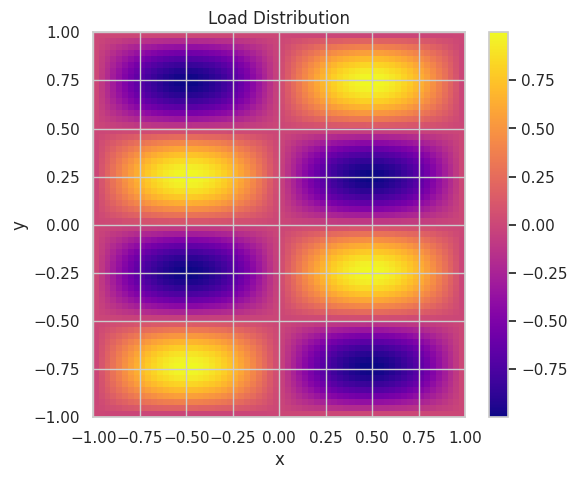

In [ ]:
u_val = lambda x, y: tf.math.sin(kx*x) * tf.math.sin(ky*y)

pde = HelmholtzPDE(u_val=u_val)

# x_collocation, y_collocation = pde.training_batch(num_points_per_dim=50)

pde.visualise()
# pde.visualise(pinn=None, x_grid=x_collocation, y_grid=y_collocation)

### Train without loss balancing
Now that the PDE has been defined, we can build the model as well as the loss function. We are first using the default HelmholtzLoss and will compare it to the ReLoBRaLoHelmholtzLoss later.

In [ ]:
pinn = HelmholtzPINN()
loss = HelmholtzLoss(pde)
pinn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss, metrics=[HelmholtzMetric(pde)])

In [ ]:
h = pinn.fit(
    pde.get_train_dataset(),
    epochs=1000,  #was 1000
    steps_per_epoch=100
)

Epoch 1/1000
100/100 [==============================] - 3s 9ms/step - loss: 24.6176 - L_f: 24.5862 - L_b: 2.8305e-04 - L_u: 0.2294 - L_u1: 0.3729 - L_inf: 1.0342
Epoch 2/1000
100/100 [==============================] - 1s 8ms/step - loss: 21.0641 - L_f: 21.0623 - L_b: 7.7699e-05 - L_u: 0.2327 - L_u1: 0.3767 - L_inf: 1.0247
Epoch 3/1000
100/100 [==============================] - 1s 8ms/step - loss: 20.6170 - L_f: 20.6220 - L_b: 2.3622e-04 - L_u: 0.2380 - L_u1: 0.3843 - L_inf: 1.0462
Epoch 4/1000
100/100 [==============================] - 1s 9ms/step - loss: 20.4441 - L_f: 20.4393 - L_b: 2.5105e-04 - L_u: 0.2387 - L_u1: 0.3848 - L_inf: 1.0502
Epoch 5/1000
100/100 [==============================] - 1s 9ms/step - loss: 20.2391 - L_f: 20.2340 - L_b: 2.5922e-04 - L_u: 0.2397 - L_u1: 0.3857 - L_inf: 1.0587
Epoch 6/1000
100/100 [==============================] - 1s 9ms/step - loss: 20.0059 - L_f: 20.0046 - L_b: 2.5965e-04 - L_u: 0.2428 - L_u1: 0.3880 - L_inf: 1.0701
Epoch 7/1000
100/100 [======

Visualise the progress of the several loss terms as well as the error against the analytical solution.

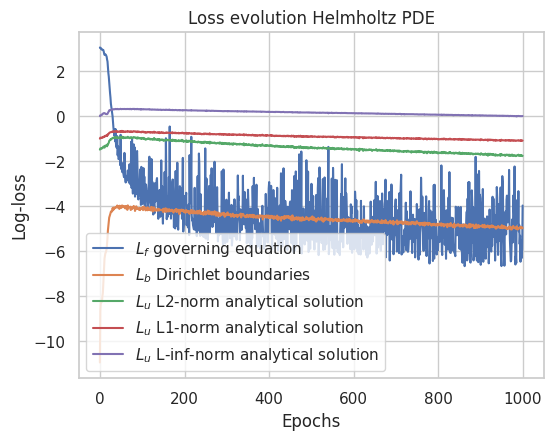

In [ ]:
fig = plt.figure(figsize=(6, 4.5), dpi=100)
plt.plot(np.log(h.history['L_f'])[:3000], label='$L_f$ governing equation')
plt.plot(np.log(h.history['L_b'])[:3000], label='$L_{b}$ Dirichlet boundaries')
plt.plot(np.log(h.history['L_u'])[:3000], label='$L_u$ L2-norm analytical solution')
plt.plot(np.log(h.history['L_u1'])[:3000], label='$L_u$ L1-norm analytical solution')
plt.plot(np.log(h.history['L_inf'])[:3000], label='$L_u$ L-inf-norm analytical solution')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Log-loss')
plt.title('Loss evolution Helmholtz PDE')
plt.show()

Visually inspect the error distribution on the physical domain.

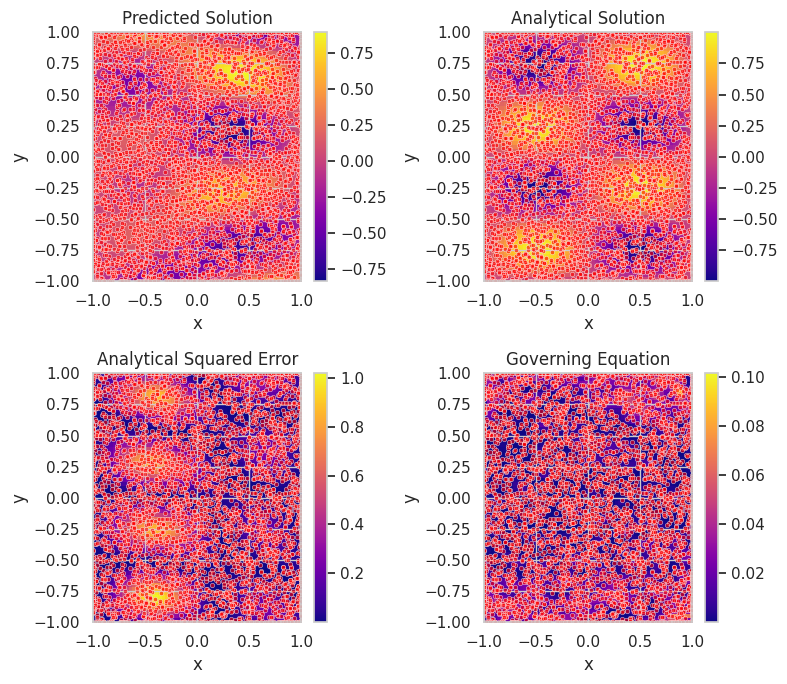

In [ ]:
pde.visualise(pinn)
# x_collocation, y_collocation = pde.training_batch(num_points_per_dim=70)
# pde.visualise(pinn, x_grid=x_collocation, y_grid=y_collocation)